# COVID-19 prediction

## Import data and packages

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
warnings.filterwarnings('ignore')


In [48]:
df = pd.read_csv('covid.csv')

In [49]:
df.head()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,previous_day_admission_pediatric_covid_confirmed_5_11,previous_day_admission_pediatric_covid_confirmed_5_11_coverage,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_unknown_coverage,staffed_icu_pediatric_patients_confirmed_covid,staffed_icu_pediatric_patients_confirmed_covid_coverage,staffed_pediatric_icu_bed_occupancy,staffed_pediatric_icu_bed_occupancy_coverage,total_staffed_pediatric_icu_beds,total_staffed_pediatric_icu_beds_coverage
0,ME,2021/01/20,3,28,8,2,29,8,7.0,38,...,NaN,0,NaN,0,NaN,0,47.0,38,54.0,38
1,SD,2021/01/20,2,60,3,2,60,3,34.0,62,...,NaN,0,NaN,0,NaN,0,33.0,62,83.0,62
2,MS,2021/01/17,12,95,2,16,91,2,10.0,107,...,NaN,0,NaN,0,NaN,0,78.0,107,180.0,107
3,CT,2021/01/13,4,35,1,4,35,1,31.0,39,...,NaN,0,NaN,0,NaN,0,196.0,39,335.0,39
4,MT,2021/01/13,10,56,1,11,55,1,18.0,66,...,NaN,0,NaN,0,NaN,0,12.0,21,40.0,21


## Initial EDA

In [50]:
# number of rows and columns
df.shape

(52445, 135)

### Lets filter out some features

Lets better understand the data types in our dataset

In [51]:
# how many columns per data type
df.dtypes.value_counts()

float64    77
int64      56
object      2
dtype: int64

What are our object columns exactly 

In [52]:
# print object columns
df.select_dtypes('object').columns


Index(['state', 'date'], dtype='object')

#### We can convert 'state' to string and 'date' to a time stamp

In [53]:
# convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# convert state column to string 
df['state'] = df['state'].astype(str)


#### Normalize "therapeutics" by beds_used_coverage

In [54]:
# divide all columns with "therapeutics" in the name by the "beds_coverage" column
cols_thera = [col for col in df.columns if 'therapeutic' in col]
for col in cols_thera:
    df[col] = df[col]/df['inpatient_beds_coverage']

#### Normalize columns by their relative counterpart

In [55]:
# find all column names pairs of ("col", "col_coverage")
cols_coverage = [col for col in df.columns if 'coverage' in col]

# col reg as cols_coverage without "_coverage"
cols_reg = [col.replace('_coverage', '') for col in cols_coverage]

In [56]:
for i in range(len(cols_reg)):
    df[cols_reg[i]] = df[cols_reg[i]]/df[cols_coverage[i]]

#### Remove utilization cols

In [57]:
# cols that have "numerator" in the name but not "numerator" or "denominator"
cols_utilization = [col for col in df.columns if 'utilization' in col and 'numerator' not in col and 'denominator' not in col]

In [58]:
# drop cols_utilization
df.drop(cols_utilization, axis=1, inplace=True)

#### Remove geocoded_state

In [59]:
# drop "geocode_state"
df.drop('geocoded_state', axis=1, inplace=True)

#### Remove columns which have a majority of Nan

In [60]:
def nan_cols(df, pct):
    """function to return columns with more than pct % of missing values"""
    lst = df.columns[df.isnull().mean() > pct]
    return lst

In [61]:
# columns with more than 50% of missing values
nan50 = nan_cols(df, 0.5)

# drop columns with more than 50% of missing values
df.drop(nan50, axis=1, inplace=True)

#### Removing data related to influenza as we are working specifically on this data 

In [62]:
# how many column names with "influenza" in it
influenza = df.columns[df.columns.str.contains('influenza')].tolist()
influenza

['icu_patients_confirmed_influenza',
 'icu_patients_confirmed_influenza_coverage',
 'previous_day_admission_influenza_confirmed',
 'previous_day_admission_influenza_confirmed_coverage',
 'previous_day_deaths_covid_and_influenza',
 'previous_day_deaths_covid_and_influenza_coverage',
 'previous_day_deaths_influenza',
 'previous_day_deaths_influenza_coverage',
 'total_patients_hospitalized_confirmed_influenza',
 'total_patients_hospitalized_confirmed_influenza_and_covid',
 'total_patients_hospitalized_confirmed_influenza_and_covid_coverage',
 'total_patients_hospitalized_confirmed_influenza_coverage']

In [63]:
# drop influenza columns
df.drop(influenza, axis=1, inplace=True)

#### Remove the columns with "coverage"

In [64]:
# create a df wihtout columns that have "coverage" in it
df = df[df.columns[~df.columns.str.contains('coverage')]]


In [65]:
# print lal variables with correlation >0.8 but not equal to 1
corr = df.corr()
# pairs above 0.7
pairs = corr[corr > 0.95][corr != 1].stack().reset_index().sort_values(by=0, ascending=False)
pairs

,level_0,level_1,0
50,adult_icu_bed_utilization_denominator,adult_icu_bed_covid_utilization_denominator,0.999836
39,adult_icu_bed_covid_utilization_denominator,adult_icu_bed_utilization_denominator,0.999836
20,percent_of_inpatients_with_covid_numerator,inpatient_bed_covid_utilization_numerator,0.999758
27,inpatient_bed_covid_utilization_numerator,percent_of_inpatients_with_covid_numerator,0.999758
29,inpatient_bed_covid_utilization_denominator,inpatient_beds_utilization_denominator,0.999106
16,inpatient_beds_utilization_denominator,inpatient_bed_covid_utilization_denominator,0.999106
9,inpatient_beds_utilization_numerator,percent_of_inpatients_with_covid_denominator,0.999066
21,percent_of_inpatients_with_covid_denominator,inpatient_beds_utilization_numerator,0.999066
14,inpatient_beds_utilization_denominator,inpatient_beds_utilization_numerator,0.992918
8,inpatient_beds_utilization_numerator,inpatient_beds_utilization_denominator,0.992918


In [66]:
# how many unique variables in pairs
pairs['level_0'].nunique()

16

#### Remove "pediatrics"

In [67]:
# remove columns with "pediatrics" in it
df.drop(df.columns[df.columns.str.contains('pediatrics')], axis=1, inplace=True)

Should we maybe do some sort of Holistic Regression or whatnot to reduce the number of variables ? or do it manually ? <br>
Do we really want to keep pediatrics ?

#### Remove "states" that are actually territories

In [68]:
# drop rows with number of points per state < 900
df = df.groupby('state').filter(lambda x: len(x) > 900)

#  how many states in df
df['state'].nunique()

53

In [69]:
# remove VI, PR and AS from df
df = df[~df['state'].isin(['VI', 'PR', 'AS'])]

#  how many states in df
df['state'].nunique()

51

In [70]:
df.shape

(50088, 64)

In [71]:
df.head()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,inpatient_beds,...,on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses,on_hand_supply_therapeutic_b_bamlanivimab_courses,on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses,previous_week_therapeutic_a_casirivimab_imdevimab_courses_used,previous_week_therapeutic_b_bamlanivimab_courses_used,previous_week_therapeutic_c_bamlanivimab_etesevimab_courses_used,all_pediatric_inpatient_bed_occupied,all_pediatric_inpatient_beds,staffed_pediatric_icu_bed_occupancy,total_staffed_pediatric_icu_beds
0,ME,2021-01-20,3,28,8,2,29,8,0.184211,83.230769,...,4.461538,8.897436,NaN,0.025641,1.384615,NaN,4.394737,5.789474,1.236842,1.421053
1,SD,2021-01-20,2,60,3,2,60,3,0.548387,43.953846,...,7.984615,14.061538,NaN,0.338462,3.753846,NaN,4.790323,5.854839,0.532258,1.338710
2,MS,2021-01-17,12,95,2,16,91,2,0.093458,79.743119,...,3.266055,24.477064,NaN,0.917431,13.889908,NaN,3.224299,22.925234,0.728972,1.682243
3,CT,2021-01-13,4,35,1,4,35,1,0.794872,211.275000,...,40.625000,86.075000,NaN,0.250000,4.850000,NaN,11.641026,17.564103,5.025641,8.589744
4,MT,2021-01-13,10,56,1,11,55,1,0.272727,48.059701,...,24.552239,7.014925,NaN,1.940299,14.134328,NaN,3.380952,7.761905,0.571429,1.904762


## Remove columns with still too many NaNs

In [26]:
# number of Nan values in each column as a dataframe
df.isna().sum().to_frame().sort_values(by=0, ascending=False).head(10)

,0
on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses,19640
previous_week_therapeutic_c_bamlanivimab_etesevimab_courses_used,19623
on_hand_supply_therapeutic_b_bamlanivimab_courses,15321
previous_week_therapeutic_b_bamlanivimab_courses_used,15285
on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses,15088
previous_week_therapeutic_a_casirivimab_imdevimab_courses_used,15087
total_staffed_pediatric_icu_beds,7768
all_pediatric_inpatient_beds,7764
staffed_pediatric_icu_bed_occupancy,7756
all_pediatric_inpatient_bed_occupied,7752


We can remove all the columns with therapeutic as they have more than 15,000 NaN

In [72]:
# print columns with "therapeutic" in column name
therapeutic = df.columns[df.columns.str.contains('therapeutic')].tolist()
therapeutic

['on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses',
 'on_hand_supply_therapeutic_b_bamlanivimab_courses',
 'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses',
 'previous_week_therapeutic_a_casirivimab_imdevimab_courses_used',
 'previous_week_therapeutic_b_bamlanivimab_courses_used',
 'previous_week_therapeutic_c_bamlanivimab_etesevimab_courses_used']

In [73]:
# drop columns with "therapeutic" in column name
df.drop(therapeutic, axis=1, inplace=True)

#### Drop all values for dates that do not have all states

<AxesSubplot:xlabel='date'>

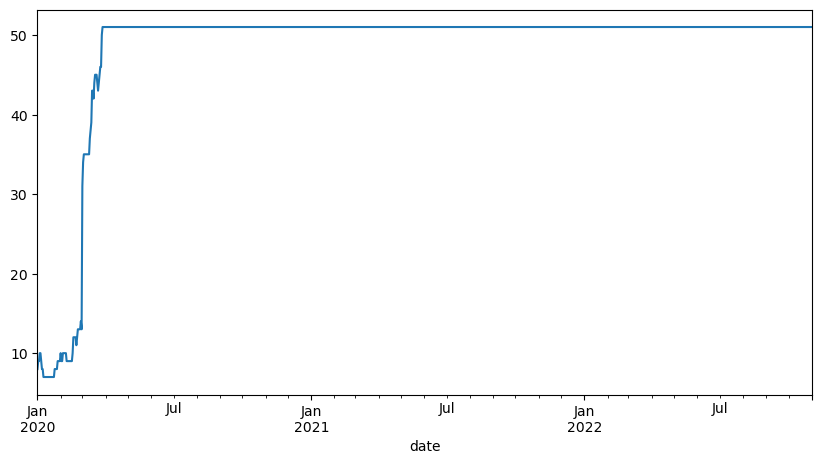

In [74]:
# how many unique states per date
# increase plot size
plt.figure(figsize=(10,5))
df.groupby('date')['state'].nunique().plot()

In [75]:
# which date are there less than 50 states
df.groupby('date')['state'].nunique().loc['2020-03-27']

50

In [76]:
df.groupby('date')['state'].nunique().loc['2020-03-28']

51

In [77]:
# convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

In [78]:
df = df.set_index('date')
df = df.sort_index(ascending=True, axis=0)

In [79]:
# drop values before 2020-03-28
df = df.loc['2020-03-28':]

In [80]:
df.head()

,state,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,inpatient_beds,inpatient_beds_used,...,previous_day_admission_adult_covid_suspected_50-59,previous_day_admission_adult_covid_suspected_60-69,previous_day_admission_adult_covid_suspected_70-79,previous_day_admission_adult_covid_suspected_80+,previous_day_admission_adult_covid_suspected_unknown,deaths_covid,all_pediatric_inpatient_bed_occupied,all_pediatric_inpatient_beds,staffed_pediatric_icu_bed_occupancy,total_staffed_pediatric_icu_beds
date,,,,,,,,,,,,,,,,,,,,,
2020-03-28,IN,0,0,15,0,0,15,0.333333,109.466667,61.933333,...,NaN,NaN,NaN,NaN,NaN,0.071429,NaN,NaN,NaN,NaN
2020-03-28,OR,0,0,7,0,0,7,0.000000,83.571429,37.285714,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2020-03-28,ND,0,0,3,0,0,3,0.000000,66.666667,7.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2020-03-28,DC,0,0,2,0,0,2,NaN,501.500000,342.500000,...,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2020-03-28,WV,0,0,7,0,0,7,0.000000,81.428571,36.571429,...,NaN,NaN,NaN,NaN,NaN,0.142857,NaN,NaN,NaN,NaN


In [81]:
# output df to csv
df.to_csv('covid_clean.csv', index=False)

#### Drop percent column

In [82]:
# print columns with percent in name and not numerator or denominator
percent = df.columns[df.columns.str.contains('percent')].tolist()
percent

['percent_of_inpatients_with_covid',
 'percent_of_inpatients_with_covid_numerator',
 'percent_of_inpatients_with_covid_denominator']

In [83]:
# drop first column of percent 
df.drop(percent[0], axis=1, inplace=True)

## Data imputation

In [84]:
# use KNN imputer to fill missing values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)

In [85]:
# df = pd.read_csv('covid_clean_imputted.csv')

In [86]:
# use KNN imputer to fill missing numeric values
df.iloc[:, 2:] = imputer.fit_transform(df.iloc[:, 2:])
# df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [87]:
#  number of Nan values in the df
df.isna().sum().sum()

0

In [88]:
# KNN imputer for string values
# df['state'] = df['state'].fillna(df['state'].mode()[0])

In [89]:
df.head()

,state,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,inpatient_beds,inpatient_beds_used,...,previous_day_admission_adult_covid_suspected_50-59,previous_day_admission_adult_covid_suspected_60-69,previous_day_admission_adult_covid_suspected_70-79,previous_day_admission_adult_covid_suspected_80+,previous_day_admission_adult_covid_suspected_unknown,deaths_covid,all_pediatric_inpatient_bed_occupied,all_pediatric_inpatient_beds,staffed_pediatric_icu_bed_occupancy,total_staffed_pediatric_icu_beds
date,,,,,,,,,,,,,,,,,,,,,
2020-03-28,IN,0,0.0,15.0,0.0,0.0,15.0,0.333333,109.466667,61.933333,...,0.025362,0.033696,0.025000,0.008696,0.000000,0.071429,5.583333,10.783333,1.925000,3.125000
2020-03-28,OR,0,0.0,7.0,0.0,0.0,7.0,0.000000,83.571429,37.285714,...,0.033333,0.040000,0.083333,0.140000,0.244444,0.000000,0.577778,9.876190,0.000000,0.057143
2020-03-28,ND,0,0.0,3.0,0.0,0.0,3.0,0.000000,66.666667,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.244444,0.000000,2.450000,6.220000,0.000000,0.000000
2020-03-28,DC,0,0.0,2.0,0.0,0.0,2.0,0.225000,501.500000,342.500000,...,0.050000,0.166667,0.016667,0.083333,0.107143,0.000000,31.160000,34.083333,13.473077,6.254396
2020-03-28,WV,0,0.0,7.0,0.0,0.0,7.0,0.000000,81.428571,36.571429,...,0.033333,0.040000,0.163333,0.140000,0.244444,0.142857,0.577778,9.876190,0.000000,0.057143


In [430]:
# # replace the row number with the date
# df['date'] = pd.to_datetime(df['date'])
# df = df.set_index('date')

In [431]:
# #  sort the index by date in ascending order and then by country in descending order 
# df = df.sort_index(ascending=True, axis=0)

# Filter VIF

In [90]:
df_=df[[
 'critical_staffing_shortage_today_yes',
 'critical_staffing_shortage_today_no',
 'critical_staffing_shortage_today_not_reported',
 'critical_staffing_shortage_anticipated_within_week_yes',
 'critical_staffing_shortage_anticipated_within_week_no',
 'critical_staffing_shortage_anticipated_within_week_not_reported',
 'hospital_onset_covid',
 'inpatient_beds',
 'inpatient_beds_used',
 'inpatient_beds_used_covid',
 'previous_day_admission_adult_covid_confirmed',
 'previous_day_admission_adult_covid_suspected',
 'previous_day_admission_pediatric_covid_confirmed',
 'previous_day_admission_pediatric_covid_suspected',
 'staffed_adult_icu_bed_occupancy',
 'staffed_icu_adult_patients_confirmed_and_suspected_covid',
 'staffed_icu_adult_patients_confirmed_covid',
 'total_adult_patients_hospitalized_confirmed_and_suspected_covid',
 'total_adult_patients_hospitalized_confirmed_covid',
 'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid',
 'total_pediatric_patients_hospitalized_confirmed_covid',
 'total_staffed_adult_icu_beds',
 'inpatient_beds_utilization_numerator',
 'inpatient_beds_utilization_denominator',
 'percent_of_inpatients_with_covid_numerator',
 'percent_of_inpatients_with_covid_denominator',
 'inpatient_bed_covid_utilization_numerator',
 'inpatient_bed_covid_utilization_denominator',
 'adult_icu_bed_covid_utilization_numerator',
 'adult_icu_bed_covid_utilization_denominator',
 'adult_icu_bed_utilization_numerator',
 'adult_icu_bed_utilization_denominator',
 'previous_day_admission_adult_covid_confirmed_18-19',
 'previous_day_admission_adult_covid_confirmed_20-29',
 'previous_day_admission_adult_covid_confirmed_30-39',
 'previous_day_admission_adult_covid_confirmed_40-49',
 'previous_day_admission_adult_covid_confirmed_50-59',
 'previous_day_admission_adult_covid_confirmed_60-69',
 'previous_day_admission_adult_covid_confirmed_70-79',
 'previous_day_admission_adult_covid_confirmed_80+',
 'previous_day_admission_adult_covid_confirmed_unknown',
 'previous_day_admission_adult_covid_suspected_18-19',
 'previous_day_admission_adult_covid_suspected_20-29',
 'previous_day_admission_adult_covid_suspected_30-39',
 'previous_day_admission_adult_covid_suspected_40-49',
 'previous_day_admission_adult_covid_suspected_50-59',
 'previous_day_admission_adult_covid_suspected_60-69',
 'previous_day_admission_adult_covid_suspected_70-79',
 'previous_day_admission_adult_covid_suspected_80+',
 'previous_day_admission_adult_covid_suspected_unknown',
 'all_pediatric_inpatient_bed_occupied',
 'all_pediatric_inpatient_beds',
 'staffed_pediatric_icu_bed_occupancy',
 'total_staffed_pediatric_icu_beds']];

In [94]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_.values, i)
                          for i in range(len(df_.columns))]

In [95]:
vif_features = vif_data.sort_values(by="VIF",ascending=False)

In [96]:
vif_features = vif_features["feature"][0:25]

In [97]:
df = df.drop(columns=vif_features)

In [98]:
# output df to csv
df.to_csv('covid_clean_imputted_vif.csv', index=True)

### Aggregate dataset by date

In [433]:
# group df by index 
df = df.groupby('date').sum()

In [434]:
df.shape

(950, 55)

#### Coverage for _yes, _no, _not_reported

In [435]:
#  variables with '_yes' in the name
cols_yes = [col for col in df.columns if '_yes' in col]
cols_nr = [col for col in df.columns if '_not_reported' in col]
cols_no = [col for col in df.columns if '_no' in col and col not in cols_nr]

for i in range(2):
    df[cols_yes[i]] = df[cols_yes[i]]/(df[cols_yes[i]] + df[cols_no[i]] + df[cols_nr[i]])
    df[cols_no[i]] = df[cols_no[i]]/(df[cols_yes[i]] + df[cols_no[i]] + df[cols_nr[i]])
    df[cols_nr[i]] = df[cols_nr[i]]/(df[cols_yes[i]] + df[cols_no[i]] + df[cols_nr[i]])

#### Utilization for num/denom

In [436]:
cols_num = [col for col in df.columns if '_numerator' in col]
cols_denom = [col for col in df.columns if '_denominator' in col]

In [437]:
# df[cols_num] = df[cols_num].div(df[cols_denom], axis=0)
for i in range(len(cols_num)):
    df[cols_num[i]] = df[cols_num[i]]/df[cols_denom[i]]

In [438]:
# drop cols_denom
df.drop(cols_denom, axis=1, inplace=True)

In [439]:
# replace "numerator" in column names with "utilization"
df.columns = df.columns.str.replace('numerator', 'utilization')

In [440]:
# export as csv
df.to_csv('covid_clean_imputted_aggregated.csv', index=True)

### Imputted and standardized

In [441]:
# standardize df
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

In [442]:
# export df to csv
df.to_csv('covid_clean_imputted_std_aggregated.csv', index=True)

### Lets build a correlation plot of the variables in our model

In [443]:
corrM = df.corr()
corrM.style.background_gradient(cmap='coolwarm',axis=None).set_precision(2)

,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,inpatient_beds,inpatient_beds_used,inpatient_beds_used_covid,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_suspected,previous_day_admission_pediatric_covid_confirmed,previous_day_admission_pediatric_covid_suspected,staffed_adult_icu_bed_occupancy,staffed_icu_adult_patients_confirmed_and_suspected_covid,staffed_icu_adult_patients_confirmed_covid,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,total_pediatric_patients_hospitalized_confirmed_covid,total_staffed_adult_icu_beds,inpatient_beds_utilization_utilization,percent_of_inpatients_with_covid_utilization,inpatient_bed_covid_utilization_utilization,adult_icu_bed_covid_utilization_utilization,adult_icu_bed_utilization_utilization,previous_day_admission_adult_covid_confirmed_18-19,previous_day_admission_adult_covid_confirmed_20-29,previous_day_admission_adult_covid_confirmed_30-39,previous_day_admission_adult_covid_confirmed_40-49,previous_day_admission_adult_covid_confirmed_50-59,previous_day_admission_adult_covid_confirmed_60-69,previous_day_admission_adult_covid_confirmed_70-79,previous_day_admission_adult_covid_confirmed_80+,previous_day_admission_adult_covid_confirmed_unknown,previous_day_admission_adult_covid_suspected_18-19,previous_day_admission_adult_covid_suspected_20-29,previous_day_admission_adult_covid_suspected_30-39,previous_day_admission_adult_covid_suspected_40-49,previous_day_admission_adult_covid_suspected_50-59,previous_day_admission_adult_covid_suspected_60-69,previous_day_admission_adult_covid_suspected_70-79,previous_day_admission_adult_covid_suspected_80+,previous_day_admission_adult_covid_suspected_unknown,deaths_covid,all_pediatric_inpatient_bed_occupied,all_pediatric_inpatient_beds,staffed_pediatric_icu_bed_occupancy,total_staffed_pediatric_icu_beds
critical_staffing_shortage_today_yes,1.00,0.85,-0.71,0.83,0.70,-0.67,0.15,-0.05,0.37,0.44,0.57,0.56,0.15,0.46,0.75,0.71,0.71,0.61,0.61,0.21,0.15,0.58,0.33,0.37,0.46,0.62,0.58,0.10,0.36,0.47,0.60,0.62,0.58,0.50,0.36,0.42,0.31,0.48,0.54,0.52,0.58,0.56,0.55,0.51,0.11,0.16,0.61,0.53,0.61,0.53
critical_staffing_shortage_today_no,0.85,1.00,-0.69,0.84,0.95,-0.72,-0.01,-0.25,0.47,0.06,0.28,0.31,0.04,0.45,0.72,0.33,0.34,0.29,0.31,0.02,-0.03,0.60,0.51,-0.02,0.10,0.22,0.46,0.03,0.13,0.22,0.29,0.31,0.26,0.21,0.13,0.08,0.14,0.28,0.37,0.32,0.40,0.37,0.37,0.34,-0.10,-0.23,0.55,0.37,0.41,0.29
critical_staffing_shortage_today_not_reported,-0.71,-0.69,1.00,-0.55,-0.57,0.98,-0.02,-0.16,-0.13,-0.27,-0.35,-0.51,0.15,-0.30,-0.42,-0.44,-0.43,-0.37,-0.35,0.17,0.18,-0.42,-0.02,-0.24,-0.26,-0.37,-0.18,0.01,-0.02,-0.10,-0.28,-0.35,-0.35,-0.35,-0.27,-0.26,-0.20,-0.29,-0.35,-0.42,-0.50,-0.51,-0.50,-0.49,-0.04,-0.08,-0.58,-0.59,-0.50,-0.52
critical_staffing_shortage_anticipated_within_week_yes,0.83,0.84,-0.55,1.00,0.86,-0.59,0.37,-0.34,0.57,0.32,0.52,0.36,0.35,0.49,0.81,0.48,0.49,0.55,0.56,0.35,0.28,0.54,0.63,0.20,0.34,0.36,0.71,0.09,0.36,0.40,0.42,0.48,0.51,0.52,0.49,0.25,0.17,0.29,0.36,0.33,0.42,0.43,0.47,0.46,-0.06,-0.06,0.19,0.02,0.11,-0.00
critical_staffing_shortage_anticipated_within_week_no,0.70,0.95,-0.57,0.86,1.00,-0.63,0.03,-0.39,0.56,-0.06,0.19,0.16,0.10,0.43,0.71,0.15,0.16,0.18,0.21,0.04,-0.01,0.55,0.64,-0.17,-0.03,0.04,0.49,0.01,0.07,0.13,0.15,0.18,0.16,0.16,0.13,-0.06,0.04,0.14,0.24,0.18,0.27,0.25,0.27,0.26,-0.20,-0.38,0.33,0.10,0.16,0.01
critical_staffing_shortage_anticipated_within_week_not_reported,-0.67,-0.72,0.98,-0.59,-0.63,1.00,-0.04,-0.09,-0.17,-0.22,-0.33,-0.44,0.13,-0.31,-0.43,-0.37,-0.36,-0.34,-0.33,0.17,0.18,-0.41,-0.09,-0.18,-0.21,-0.29,

In [444]:
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corrM, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corrM[mask] = np.nan
(corrM
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,inpatient_beds,inpatient_beds_used,inpatient_beds_used_covid,previous_day_admission_adult_covid_confirmed,previous_day_admission_adult_covid_suspected,previous_day_admission_pediatric_covid_confirmed,previous_day_admission_pediatric_covid_suspected,staffed_adult_icu_bed_occupancy,staffed_icu_adult_patients_confirmed_and_suspected_covid,staffed_icu_adult_patients_confirmed_covid,total_adult_patients_hospitalized_confirmed_and_suspected_covid,total_adult_patients_hospitalized_confirmed_covid,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid,total_pediatric_patients_hospitalized_confirmed_covid,total_staffed_adult_icu_beds,inpatient_beds_utilization_utilization,percent_of_inpatients_with_covid_utilization,inpatient_bed_covid_utilization_utilization,adult_icu_bed_covid_utilization_utilization,adult_icu_bed_utilization_utilization,previous_day_admission_adult_covid_confirmed_18-19,previous_day_admission_adult_covid_confirmed_20-29,previous_day_admission_adult_covid_confirmed_30-39,previous_day_admission_adult_covid_confirmed_40-49,previous_day_admission_adult_covid_confirmed_50-59,previous_day_admission_adult_covid_confirmed_60-69,previous_day_admission_adult_covid_confirmed_70-79,previous_day_admission_adult_covid_confirmed_80+,previous_day_admission_adult_covid_confirmed_unknown,previous_day_admission_adult_covid_suspected_18-19,previous_day_admission_adult_covid_suspected_20-29,previous_day_admission_adult_covid_suspected_30-39,previous_day_admission_adult_covid_suspected_40-49,previous_day_admission_adult_covid_suspected_50-59,previous_day_admission_adult_covid_suspected_60-69,previous_day_admission_adult_covid_suspected_70-79,previous_day_admission_adult_covid_suspected_80+,previous_day_admission_adult_covid_suspected_unknown,deaths_covid,all_pediatric_inpatient_bed_occupied,all_pediatric_inpatient_beds,staffed_pediatric_icu_bed_occupancy,total_staffed_pediatric_icu_beds
critical_staffing_shortage_today_yes,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
critical_staffing_shortage_today_no,0.85,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
critical_staffing_shortage_today_not_reported,-0.71,-0.69,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
critical_staffing_shortage_anticipated_within_week_yes,0.83,0.84,-0.55,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
critical_staffing_shortage_anticipated_within_week_no,0.70,0.95,-0.57,0.86,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
critical_staffing_shortage_anticipated_within_week_not_reported,-0.67,-0.72,0.98,-0.59,-0.63,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
hospital_onset_covid,0.15,-0.01,-0.02,0.37,0.03,-0.04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
inpatient_beds,-0.0